# Aspinity analysis of Ring test results

Results came in a spreadsheet. This has been converted to a Matlab cell array for easier parsing.

In [3]:
load 2020-10-08-a-aspinf-ts123.mat; % Loads into alldata variable

# First, let's understand the test matrix
For the level definitions, they said they are using peak levels in both the glassbreak and the background files. They are using $0 \text{dB}_\text{FS} = 130 \text{dB}_\text{SPL,C}$.

## Event breakdown
There are 6000 events with a mix of glass break and non-glassbreak. It is roughly an equal split.

In [4]:
Test_type = alldata(3:end, 2);
Labels = zeros(size(Test_type));
Labels(strmatch('FR', Test_type, 'exact')) = 1;

printf('%d glassbreak events and %d disturber events\n', sum(Labels), sum(Labels==0));

3048 glassbreak events and 2952 disturber events


## Foreground and background levels

Glassbreak max SPL = 56, min SPL = 128
False alarm max SPL = 66, min SPL = 126
Background max SPL = 31, min SPL = 96


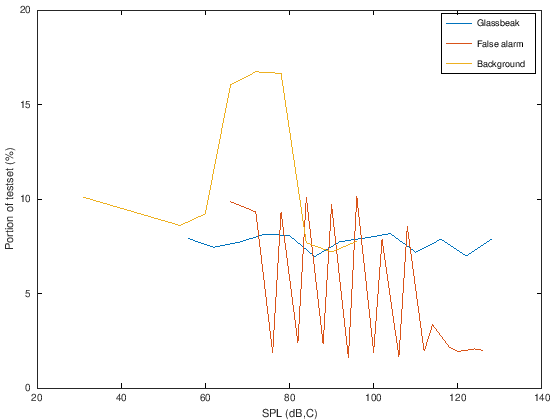

In [5]:
% Foreground
FG_dBspl = cell2mat( alldata(3:end, 6) );

GB_dBfs  = cell2mat( alldata(2+find(Labels==1), 5) );
GB_dBspl = cell2mat( alldata(2+find(Labels==1), 6) );
printf('Glassbreak max SPL = %d, min SPL = %d\n', min(GB_dBspl), max(GB_dBspl));

FA_dBfs  = cell2mat( alldata(2+find(Labels==0), 5) );
FA_dBspl = cell2mat( alldata(2+find(Labels==0), 6) );
printf('False alarm max SPL = %d, min SPL = %d\n', min(FA_dBspl), max(FA_dBspl));

% Background
BG_dBfs  = cell2mat( alldata(3:end, 9) );
BG_dBspl = cell2mat( alldata(3:end, 10) );
printf('Background max SPL = %d, min SPL = %d\n', min(BG_dBspl), max(BG_dBspl));

% And how was it sampled?
% Found that they are only using 33 event levels and 9 background levels
[GB_hist_y, GB_hist_x] = hist(GB_dBspl, unique(GB_dBspl));
[FA_hist_y, FA_hist_x] = hist(FA_dBspl, unique(FA_dBspl));
[BG_hist_y, BG_hist_x] = hist(BG_dBspl, unique(BG_dBspl));

% Normalize to percentage
GB_hist_y = 100 * GB_hist_y / sum(GB_hist_y);
FA_hist_y = 100 * FA_hist_y / sum(FA_hist_y);
BG_hist_y = 100 * BG_hist_y / sum(BG_hist_y);

plot(GB_hist_x, GB_hist_y, FA_hist_x, FA_hist_y, BG_hist_x, BG_hist_y);
xlabel('SPL (dB,C)'); ylabel('Portion of testset (%)');
legend('Glassbeak', 'False alarm', 'Background')

These are the unique levels

In [6]:
printf('*** Glassbreak SPLs ***\n');
for i = 1:length(GB_hist_x)
  printf('%d, ', GB_hist_x(i));
end
printf('\n');

printf('*** False alarm SPLs ***\n');
for i = 1:length(FA_hist_x)
  printf('%d, ', FA_hist_x(i));
end
printf('\n');

printf('*** Background SPLs ***\n');
for i = 1:length(BG_hist_x)
  printf('%d, ', BG_hist_x(i));
end
printf('\n');

*** Glassbreak SPLs ***
56, 62, 68, 74, 80, 86, 92, 98, 104, 110, 116, 122, 128, 
*** False alarm SPLs ***
66, 72, 76, 78, 82, 84, 88, 90, 94, 96, 100, 102, 106, 108, 112, 114, 118, 120, 124, 126, 
*** Background SPLs ***
31, 54, 60, 66, 72, 78, 84, 90, 96, 


## SNR range

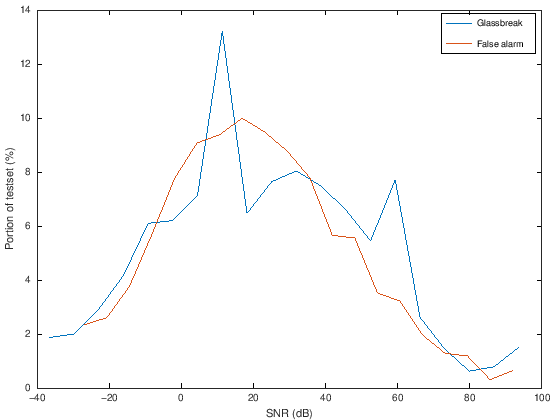

In [7]:
GB_SNR_dB = GB_dBspl - BG_dBspl(Labels == 1);
[GB_SNR_hist_y, GB_SNR_hist_x] = hist(GB_SNR_dB, 20);

FA_SNR_dB = FA_dBspl - BG_dBspl(Labels == 0);
[FA_SNR_hist_y, FA_SNR_hist_x] = hist(FA_SNR_dB, 20);

% Normalize to percentage
GB_SNR_hist_y = 100 * GB_SNR_hist_y / sum(GB_SNR_hist_y);
FA_SNR_hist_y = 100 * FA_SNR_hist_y / sum(FA_SNR_hist_y);

plot(GB_SNR_hist_x, GB_SNR_hist_y, FA_SNR_hist_x, FA_SNR_hist_y);
xlabel('SNR (dB)'); ylabel('Portion of testset (%)')
legend('Glassbreak', 'False alarm');

# Extract basic performance metrics
## Performance in silence (SNR > 40dB)

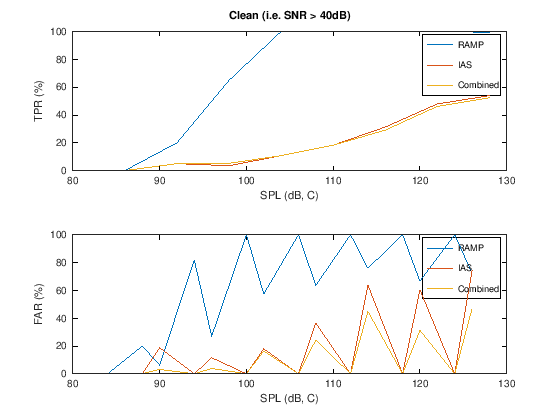

In [8]:
RAMP = cell2mat( alldata(3:end, 11) );
IAS  = cell2mat( alldata(3:end, 13) );
FULL = cell2mat( alldata(3:end, 12) );

% False reject
FR = zeros(length(GB_hist_x), 3); % Three columns for RAMP, IAS, and FULL
for i = 1:length(GB_hist_x)
    FR_index = find(FG_dBspl == GB_hist_x(i) ...
                    & Labels == 1 ...
                    & (FG_dBspl-BG_dBspl) >= 40);
    FR(i, 1) = mean(RAMP(FR_index)==0);
    FR(i, 2) = mean(IAS(FR_index)==0);
    FR(i, 3) = mean(FULL(FR_index)==0);
end

subplot(2, 1, 1);
plot(GB_hist_x, 100*(1-FR));
xlim([80 130]);
xlabel('SPL (dB, C)'); ylabel('TPR (%)');
legend('RAMP', 'IAS', 'Combined');
title('Clean (i.e. SNR > 40dB)');

% False alarm
FA = zeros(length(FA_hist_x), 3); % Three columns for RAMP, IAS, and FULL
for i = 1:length(FA_hist_x)
    FA_index = find(FG_dBspl == FA_hist_x(i) ...
                    & Labels == 0 ...
                    & (FG_dBspl-BG_dBspl) >= 40);
    FA(i, 1) = mean(RAMP(FA_index)>0);
    FA(i, 2) = mean(IAS(FA_index)>0);
    FA(i, 3) = mean(FULL(FA_index)>0);
end

subplot(2, 1, 2);
plot(FA_hist_x, 100*FA);
xlim([80 130]);
xlabel('SPL (dB, C)'); ylabel('FAR (%)');
legend('RAMP', 'IAS', 'Combined');

**Notes:** 
* We designed for 85dBSPL to 110dBSPL as measured by averaging over the whole glassbreak event. They are measuring levels based on the peak. This will shift the curves up. When we looked at averaging over the whole glass break event vs averaging over the first 200ms, we saw the shorter time frame shifted the numbers up 5dB. If they are taking peak (probably over ~20ms for typical audio analysis) then it's probably another 5-10dB shift. So our 85dB low-end target would correspond to about 100dB in this graph, so it roughly matches with our target.
* FAR plot is weird. They must be alternating types of FA events at each SPL step. Very interesting that we have such high sensitivity to the events that IAS has no sensitivity to. But RAMP and IAS both seem to mirror the GB results in these FAR results. **See below for further investigation. It looks like the false alarm events that we are so sensitive to are window impacts that don't cause the window to break, so we probably should detect those.**

## Event distribution

In [11]:
alldata(1, :)
alldata(2, :)

ans =
{
  [1,1] =  NaN
  [1,2] =  NaN
  [1,3] = FOREGROUND
  [1,4] =  NaN
  [1,5] =  NaN
  [1,6] =  NaN
  [1,7] = BACKGROUND
  [1,8] =  NaN
  [1,9] =  NaN
  [1,10] =  NaN
  [1,11] = TEST RESULTS
  [1,12] =  NaN
  [1,13] =  NaN
  [1,14] =  NaN
  [1,15] =  NaN
  [1,16] = E02 glass break data
  [1,17] =  NaN
  [1,18] =  NaN
  [1,19] =  NaN
  [1,20] =  NaN
  [1,21] =  NaN
  [1,22] =  NaN
  [1,23] =  NaN
}

ans =
{
  [1,1] = Test ID
  [1,2] = Test type
  [1,3] = FG code
  [1,4] = FG layer name
  [1,5] = FG dB (mix)
  [1,6] = FG SPL dBc
  [1,7] = BG code
  [1,8] = BG layer name
  [1,9] = BG dB (mix)
  [1,10] = BG SPL dBc
  [1,11] = FULL RAMP
  [1,12] = FULL IAS
  [1,13] = SOLO IAS
  [1,14] = Overall result
  [1,15] = Components agree
  [1,16] = Event ID
  [1,17] = Event code
  [1,18] = Sub- event code
  [1,19] = Glass type
  [1,20] = Glass thick
  [1,21] = Window panes
  [1,22] = Impactor
  [1,23] = Mode
}



In [23]:
[GBtypes, ~, GBtypes_index] = unique( alldata(2+find(Labels==1), 4) );
[FAtypes, ~, FAtypes_index] = unique( alldata(2+find(Labels==0), 4) );
[BGtypes, ~, BGtypes_index] = unique( alldata(2+find(Labels==0), 8) );
printf('# of GB types = %d\n', length(GBtypes));
printf('# of FA types = %d\n', length(FAtypes));
printf('# of BG types = %d\n', length(BGtypes));

printf('\n*** Background types ***\n')
BGtypes

# of GB types = 837
# of FA types = 575
# of BG types = 13

*** Background types ***
BGtypes =
{
  [1,1] = BLIB_3DS04_0009-HeaterHumClicking-01
  [2,1] = BLIB_3DS04_0011-RoomQuietThrumming-01
  [3,1] = BLIB_3DS04_0019-LivingRoomWood-01
  [4,1] = BLIB_3DS04_0020-BedroomQuiet-01
  [5,1] = BLIB_3DS04_0025-RoomMediumRain-01
  [6,1] = BLIB_3DS04_0029-RoomLargeRainDrone-01
  [7,1] = BLIB_3DS04_0031-Rain-01
  [8,1] = BLIB_3DS04_0033-CityApartmentNight-01
  [9,1] = FS-340020-01-livingRoomTVambience
  [10,1] = FS-474395-01-CNNbackground
  [11,1] = GEN-silence
  [12,1] = SI6K-6014-30-1
  [13,1] = SI6K-6014-31-1
}



## FA events across sawtooth SPL

In [45]:
FA_low_nD = [];
FA_high_nD = [];

for i = 1:2:length(FA_hist_x)
  % High point on odd numbers
  nD = find(FG_dBspl == FA_hist_x(i) ...
            & Labels == 0 ...
            & (FG_dBspl-BG_dBspl) >= 40);
  FA_high_nD = [FA_high_nD; nD];

  % Low point on even numbers
  nD = find(FG_dBspl == FA_hist_x(i+1) ...
            & Labels == 0 ...
            & (FG_dBspl-BG_dBspl) >= 40);
  FA_low_nD = [FA_low_nD; nD];
end

[FA_low_types] = unique( alldata(2+FA_low_nD, 3) );
[FA_high_types] = unique( alldata(2+FA_high_nD, 3) );

printf('"FG code"s for FA events that had low detection rate:\n')
FA_low_types

printf('"FG code"s for FA events that had high detection rate:\n')
FA_high_types

"FG code"s for FA events that had low detection rate:
FA_low_types =
{
  [1,1] = MUS
  [2,1] = NG01
  [3,1] = NG21
  [4,1] = NG22
  [5,1] = NG23
  [6,1] = NG31
  [7,1] = NG32
  [8,1] = NG33
  [9,1] = NG41
  [10,1] = NG42
}

"FG code"s for FA events that had high detection rate:
FA_high_types =
{
  [1,1] = E02
}



We had the highest detection rates for code type E02. It looks like the E02 type may have been window impacts that didn't break. They mentioned having this type of false alarm event. My suspicion that E02 corresponds to the window impacts comes from:
- The glass break events have foreground code GBE-E02
- The event names for the E02 events `055-T18M5C-02-tGT0-m2` are similar names as the GBE-E02 events `058-T24M4C-09-tGT2-m1` but different from the naming schemes of the other false alarm events.

Arguably the RAMP should detect the window impacts if it is going to act as a quick detector.

## Non-window related false alarm events

In [46]:
[FA_nonWindow_types] = unique( alldata(2+FA_low_nD, 4) );

The unique false alarm types are:

```
8888
bangarang
birdScreech
bullTerrierBarking
buzz
cabinetDoorClose
chicaBomb
chirp
clicks
coin-handling
coin-in-coin-jar
coins
coins-in-coin-jar
coins-in-drawer
coins-on-stone-floor
croak
dishClatter
dogBark
dogGrowling
door-close
door-close-binding
door-open
drawerClose
drawerOpen
drawerOpenCoins
drawerRummage
femaleVoiceGiggle
getAmoveOn
handling-coins
isntThatWild
keyJangle
landOfConfusionLive
latch
latch-open
latch-open-squeak
macaw-croak
macaw-screech
manWomanLaughing
moneyForNothing
noSpeakAmericano
nomad
parrotHonk
parrotScream
petraParrotChirps
playTheGame
rainbowsInTheDark
silentPlanet
smallDogBarking
spanishMale
spanishManWoman
sukkerchock
sweat
takeFive
toolDrawerRummage
tweet
weWillRockYou
```

## Further questions
- performance over FAR type
- performance over glassbreak type
  - Tempered vs conventional
  - Thickness
  - \# panes
  - Impactor
  - Mode
- include low SNR cases